In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
net = melt.image.get_imagenet_from_checkpoint(FLAGS.image_checkpoint_file)
print('image net', net, 'net.default_image_size', net.default_image_size)
FLAGS.image_model_name = FLAGS.image_model_name or net.name
FLAGS.image_height = FLAGS.image_height or net.default_image_size
FLAGS.image_width = FLAGS.image_width or net.default_image_size
image_model_name = FLAGS.image_model_name

#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell2.finetune/'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.coverage.finetune.biglr3/'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords'
FLAGS.model_dir = model_dir


if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name)
else:
  image_model = None

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0-rc1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
image net <function inception_resnet_v2 at 0x7f9e00f1ded8> net.default_image_size 299


ENCODE_UNK 1


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_attention_size = 64 
FLAGS.image_endpoint_feature_name = 'Conv2d_7b_1x1'
FLAGS.image_model = 'InceptionResnetV2'
FLAGS.image_checkpoint_file = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt' 
FLAGS.pre_calc_image_feature = 0 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.image_features_drop_out = True
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.image_feature_len = 1536 * 64
FLAGS.alignment_history = True

beam_size = 10
length_normalization_factor = 0.25

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init()
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True)  

predictor.load(FLAGS.model_dir) 

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
preprocessing_fn net_name inception_resnet_v2 height 299 width 299
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("show_and_tell/main/encode/Flatten/flatten/Reshape:0", shape=(?, 98304), dtype=float32)
use melt.seq2seq.CoverageBahdanauAttention


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.coverage.finetune.biglr3/model.ckpt-31.34-456000


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.coverage.finetune.biglr3/model.ckpt-31.34-456000
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.coverage.finetune.biglr3/model.ckpt-31.34-456000 duration: 14.0950469971


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 0d5bb5c1fcebec433bdd5a636c85e907d0d40535


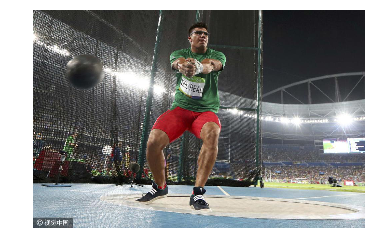

一个 穿着 运动服 的 男人 在 运动场 上 腾空 跃起 </S> 0.0899346
probs [0.5233628293873271, 0.6046223095878122, 0.5888768769595413, 0.9647271050432624, 0.7656616928005794, 0.829711237535249, 0.7965442319960246, 0.9351940152597257, 0.24197903585044478, 0.6099757185670309, 0.990948270205397, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


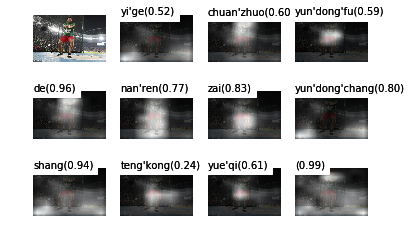

beam search using time(ms): 4336.85302734
一个 穿着 运动服 的 男人 在 运动场 上 扔 链球 </S> 0.0693421
probs [0.5233628293873271, 0.6046223095878122, 0.5888768769595413, 0.9647271050432624, 0.7656616928005794, 0.829711237535249, 0.7965442319960246, 0.9351940152597257, 0.2220460923361833, 0.4156411688820034, 0.9869991000705817, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


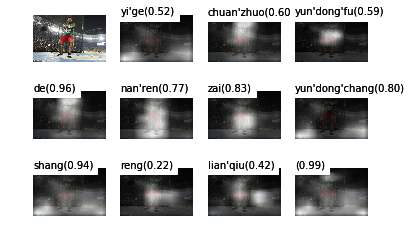

beam search using time(ms): 1690.08493423
一个 穿着 运动服 的 男人 在 运动场 上 扔 铅球 </S> 0.068532
probs [0.5233628293873271, 0.6046223095878122, 0.5888768769595413, 0.9647271050432624, 0.7656616928005794, 0.829711237535249, 0.7965442319960246, 0.9351940152597257, 0.2220460923361833, 0.4029600536941174, 0.9965031073346448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


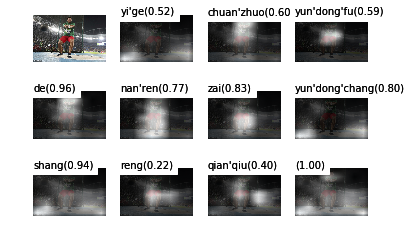

beam search using time(ms): 1677.21295357
运动场 上 有 一个 穿着 运动服 的 男人 在 扔 链球 </S> 0.068079
probs [0.2738162929615675, 0.9515616700353801, 0.6942885494226401, 0.9661922876631586, 0.6757131224336675, 0.7005441188515265, 0.9878291963346391, 0.8401669272696021, 0.9543975971716941, 0.188721913010388, 0.5476899083447747, 0.9934838434784852, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


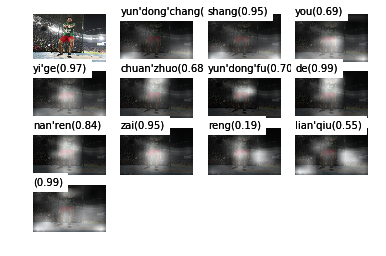

beam search using time(ms): 1828.0620575
一个 双手 抬起 的 男人 在 运动场 上 腾空 跃起 </S> 0.0672113
probs [0.5233628293873271, 0.20325023192179617, 0.3815680807896182, 0.9665386176749736, 0.9288345907932222, 0.7275410641182106, 0.7645194530770032, 0.9681684034702802, 0.6250173566903509, 0.6028419052525947, 0.9902121530624245, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


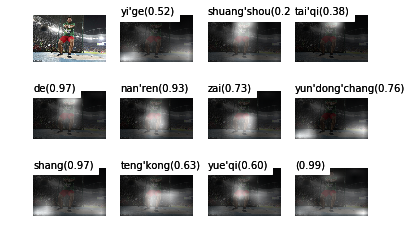

beam search using time(ms): 1443.17793846
运动场 上 有 一个 穿着 运动服 的 男人 在 举重 </S> 0.0596094
probs [0.2738162929615675, 0.9515616700353801, 0.6942885494226401, 0.9661922876631586, 0.6757131224336675, 0.7005441188515265, 0.9878291963346391, 0.8401669272696021, 0.9543975971716941, 0.09020517355384723, 0.9952798820986738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


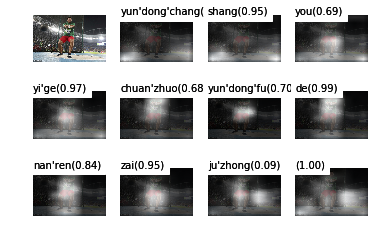

beam search using time(ms): 1451.81512833
一个 穿着 运动服 的 男人 在 运动场 上 腾空 跳 起 </S> 0.0553191
probs [0.5233628293873271, 0.6046223095878122, 0.5888768769595413, 0.9647271050432624, 0.7656616928005794, 0.829711237535249, 0.7965442319960246, 0.9351940152597257, 0.24197903585044478, 0.23388367464872992, 0.9868117019676156, 0.962549685726091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


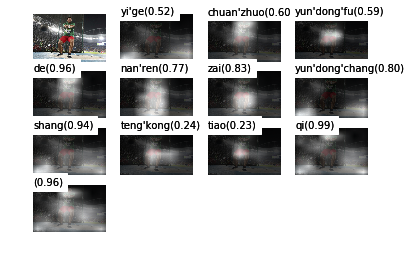

beam search using time(ms): 1670.73488235
一个 穿着 运动服 的 男人 在 运动场 上 举重 </S> 0.0546723
probs [0.5233628293873271, 0.6046223095878122, 0.5888768769595413, 0.9647271050432624, 0.7656616928005794, 0.829711237535249, 0.7965442319960246, 0.9351940152597257, 0.0673538701688212, 0.993672136615793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


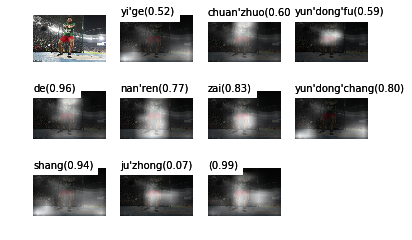

beam search using time(ms): 1535.31813622
运动场 上 有 一个 穿着 运动服 的 男人 在 跳远 </S> 0.0491927
probs [0.2738162929615675, 0.9515616700353801, 0.6942885494226401, 0.9661922876631586, 0.6757131224336675, 0.7005441188515265, 0.9878291963346391, 0.8401669272696021, 0.9543975971716941, 0.06342309690816553, 0.9977445327649369, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


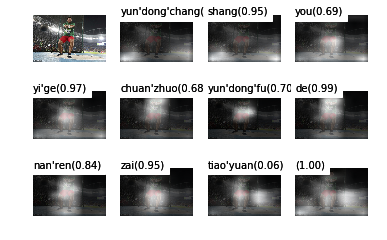

beam search using time(ms): 1359.43198204
一个 双手 抬起 的 男人 在 运动场 上 腾空 跳 起 </S> 0.0457807
probs [0.5233628293873271, 0.20325023192179617, 0.3815680807896182, 0.9665386176749736, 0.9288345907932222, 0.7275410641182106, 0.7645194530770032, 0.9681684034702802, 0.6250173566903509, 0.2735108416024803, 0.9874219934823989, 0.9707737062481582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


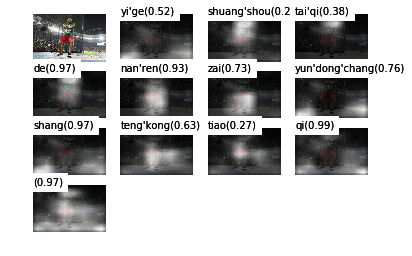

beam search using time(ms): 2561.20681763
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: jpg:dbfa2971caf54f7700e882609bb563ef9b032193
path not exists:/home/gezi/data2/data/ai_challenger/image_caption/pic/jpg:dbfa2971caf54f7700e882609bb563ef9b032193.jpg
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: dbfa2971caf54f7700e882609bb563ef9b032193


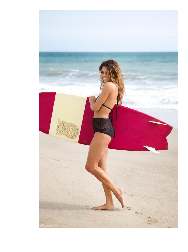

一个 穿着 比基尼 的 女人 站 在 海边 的 沙滩 上 </S> 0.124754
probs [0.5050540666681238, 0.3240968015843046, 0.44871767194547346, 0.9062126071450088, 0.93074930674692, 0.5051724176594838, 0.9988180081420336, 0.721147404801691, 0.9740779129443344, 0.9855221680492305, 0.9936935596094176, 0.9661809353901835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


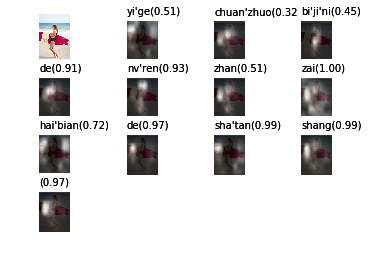

beam search using time(ms): 2584.11192894
一个 双手 抱 着 冲浪板 的 女人 站 在 海边 的 沙滩 上 </S> 0.0936679
probs [0.5050540666681238, 0.24806010205953755, 0.3707144828863667, 0.921814318147851, 0.8340704788651822, 0.97648788112899, 0.974670059138911, 0.7590195465628715, 0.9980473573386552, 0.4476497336528896, 0.9116708436605632, 0.9875384687545088, 0.99355632820242, 0.9942114019064768, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


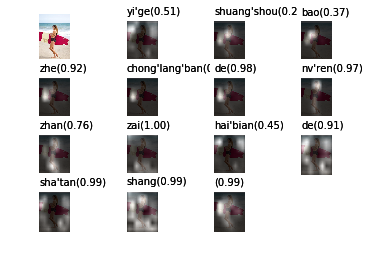

beam search using time(ms): 6363.15703392
一个 双手 拿 着 冲浪板 的 女人 站 在 海边 的 沙滩 上 </S> 0.081679
probs [0.5050540666681238, 0.24806010205953755, 0.3586083698174541, 0.9950640664655321, 0.5515343105928433, 0.9872543033384765, 0.9679898734420624, 0.7820592887962294, 0.9985069903029133, 0.4748168453610292, 0.9213377573685528, 0.9883181205186291, 0.9952812989070243, 0.9932042428723167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


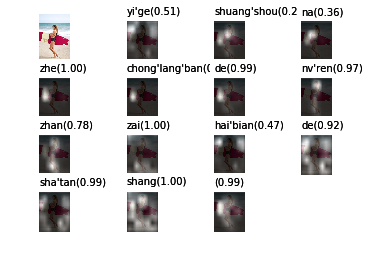

beam search using time(ms): 7237.60604858
一个 穿着 泳衣 的 女人 站 在 海边 的 沙滩 上 </S> 0.0770957
probs [0.5050540666681238, 0.3240968015843046, 0.18689876767617303, 0.9156110710734631, 0.9252602082208552, 0.49690211778927584, 0.9989213669408079, 0.7208901500607426, 0.9712968312222174, 0.9850430624230624, 0.9929910894262176, 0.9627477593244745, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


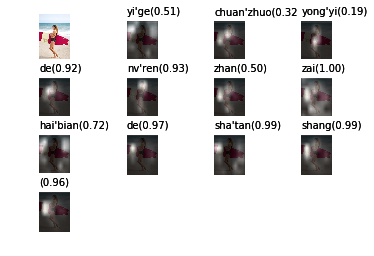

beam search using time(ms): 2011.96908951
海边 的 沙滩 上 站 着 一个 双手 抱 着 冲浪板 的 女人 </S> 0.0711698
probs [0.18140552526615653, 0.6891893466114244, 0.9823467932704925, 0.9886350568314785, 0.6012581585341267, 0.9997782007205326, 0.7377183704456728, 0.38857037927630567, 0.3964024348763194, 0.908281579671073, 0.8319874998309422, 0.9798861056153523, 0.9820750341392904, 0.9989518196209974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


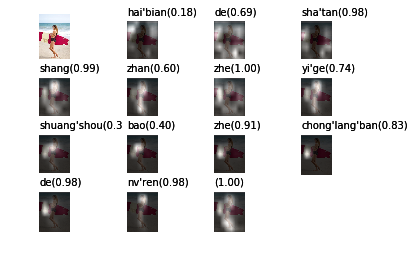

beam search using time(ms): 1622.18785286
海边 的 沙滩 上 站 着 一个 穿着 比基尼 的 女人 </S> 0.0589122
probs [0.18140552526615653, 0.6891893466114244, 0.9823467932704925, 0.9886350568314785, 0.6012581585341267, 0.9997782007205326, 0.7377183704456728, 0.16463588941729504, 0.6599989124598704, 0.9522095369286727, 0.9315796125254926, 0.9906679886385312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


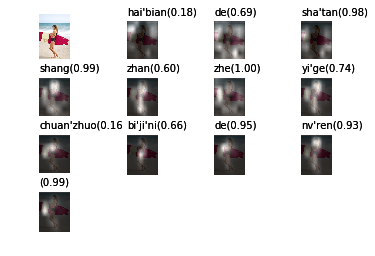

beam search using time(ms): 1331.57420158
海边 的 沙滩 上 站 着 一个 双手 拿 着 冲浪板 的 女人 </S> 0.0506257
probs [0.18140552526615653, 0.6891893466114244, 0.9823467932704925, 0.9886350568314785, 0.6012581585341267, 0.9997782007205326, 0.7377183704456728, 0.38857037927630567, 0.2709372190931115, 0.9877856929175328, 0.577110869143603, 0.9902479215042728, 0.9756511957277378, 0.9985566735101478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


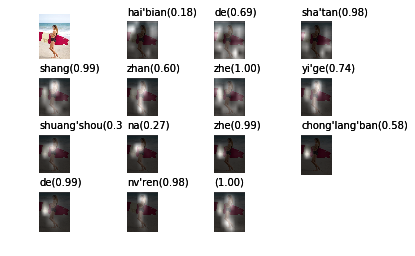

beam search using time(ms): 1509.05299187
海边 的 沙滩 上 站 着 一位 双手 抱 着 冲浪板 的 女士 </S> 0.0450345
probs [0.18140552526615653, 0.6891893466114244, 0.9823467932704925, 0.9886350568314785, 0.6012581585341267, 0.9997782007205326, 0.2558966981895646, 0.3605826531879631, 0.47572179131793707, 0.9507084119764526, 0.9202575822095396, 0.9926022883328787, 0.8940876062168308, 0.9993426355404706, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


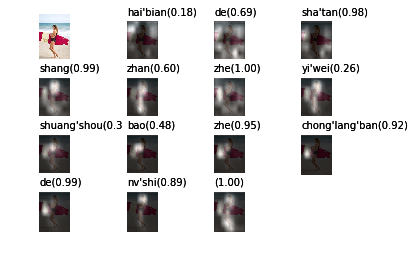

beam search using time(ms): 1531.14795685
一个 双手 抱 着 冲浪板 的 女人 站 在 柔软 的 沙滩 上 </S> 0.0440854
probs [0.5050540666681238, 0.24806010205953755, 0.3707144828863667, 0.921814318147851, 0.8340704788651822, 0.97648788112899, 0.974670059138911, 0.7590195465628715, 0.9980473573386552, 0.13921286785538406, 0.6806397098815539, 0.9878996947423049, 0.9940014677124495, 0.9958744485366054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


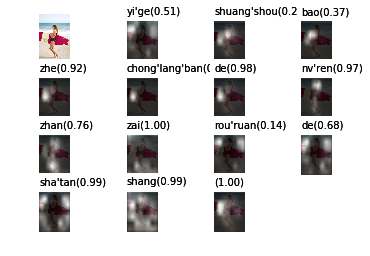

beam search using time(ms): 1641.89100266
一个 双手 抱 着 冲浪板 的 女人 站 在 沙滩 上 </S> 0.0439744
probs [0.5050540666681238, 0.24806010205953755, 0.3707144828863667, 0.921814318147851, 0.8340704788651822, 0.97648788112899, 0.974670059138911, 0.7590195465628715, 0.9980473573386552, 0.12375873770882924, 0.9651239087924534, 0.9701565481115948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


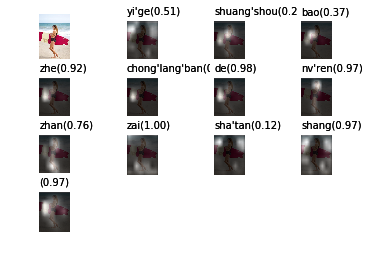

beam search using time(ms): 1338.73796463


In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)